# Лабораторная работа №6. .
## Применение сверточных нейронных сетей (многоклассовая классификация)


### Данные
Набор данных для распознавания языка жестов, который состоит из изображений размерности 28x28 в оттенках серого (значение пикселя от 0 до 255). 
Каждое из изображений обозначает букву латинского алфавита, обозначенную с помощью жеста, как показано на рисунке ниже (рисунок цветной, а изображения в наборе данных в оттенках серого). 
Обучающая выборка включает в себя 27,455 изображений, а контрольная выборка содержит 7172 изображения. 
Данные в виде csv-файлов можно скачать на сайте 
Kaggle -> https://www.kaggle.com/datamunge/sign-language-mnist


### Задания
- [x] Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.
- [x] Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?
- [x] Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 
- [x] Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. 
- [ ] Как это повлияло на качество классификатора? Можно ли было обойтись без него?
- [ ] Какой максимальный результат удалось получить на контрольной выборке?

In [1]:
import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import warnings
warnings.filterwarnings('ignore')
import skimage
import random
import zipfile
from pathlib import Path

import cv2
import numpy as np

import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd
import keras as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def prepare_data(df):
    images = df.loc[:, df.columns != 'label']
    m, img_vector = images.values.shape
    X = images.values.reshape(m, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
    X = X / 255
    Y = K.utils.to_categorical(df['label'].values)
    return X, Y


def plot_history(history):
    _, ax = plt.subplots(1, 2, figsize= (16, 8))

    ax[0].set_title('Accuracy')
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'], color='green')
    ax[0].legend(['train', 'val'], loc='best')

    ax[1].set_title('Loss')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'], color='green')
    ax[1].legend(['train', 'val'], loc='best')

In [3]:
# Image configuration
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)


# Data pathes
unzip_dir = Path('data/sign-language-mnist')
test_dir = unzip_dir / 'sign_mnist_test'
train_dir = unzip_dir / 'sign_mnist_train'

data_zip = Path('data/sign-language-mnist.zip')


# Extract data
if not unzip_dir.exists():
    with zipfile.ZipFile(data_zip, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)


# Read Data
train_df = pd.read_csv(train_dir / 'sign_mnist_train.csv').reset_index(drop=True)
test_df = pd.read_csv(test_dir / 'sign_mnist_test.csv').reset_index(drop=True)

print('Train shape ', train_df.shape)
print('Test shape  ', test_df.shape)

Train shape  (27455, 785)
Test shape   (7172, 785)


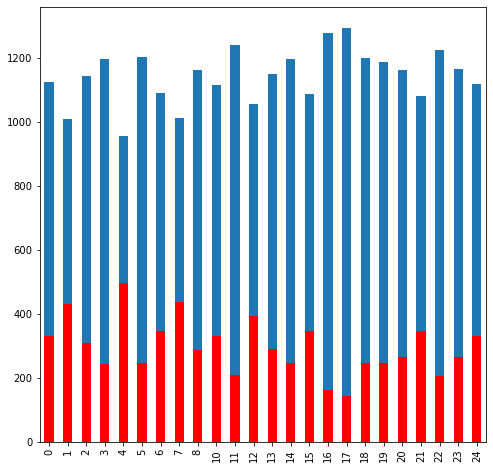

In [4]:
_, ax = plt.subplots(1, 1, figsize=(8, 8))
train_df['label'].value_counts().sort_index().plot.bar(ax=ax)
test_df['label'].value_counts().sort_index().plot.bar(ax=ax, color='red')

In [5]:
# Prepare data
train_X, train_Y = prepare_data(train_df)
test_X, test_Y = prepare_data(test_df)

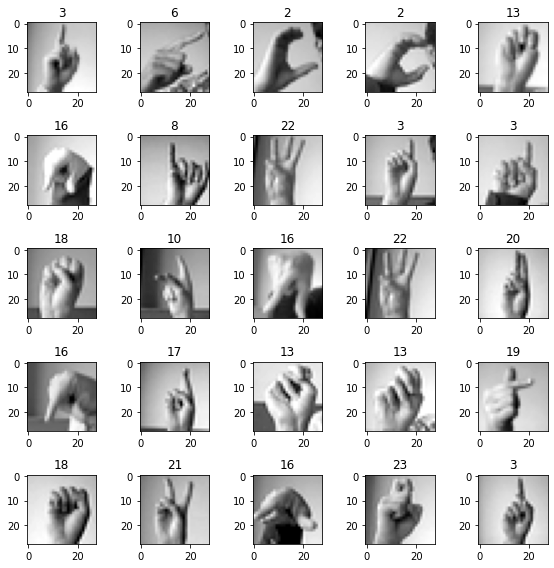

In [6]:
# Print image
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    img = train_X[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
    plt.imshow(img, cmap='gray')
    plt.title(train_Y[i].argmax())
plt.tight_layout()

In [7]:
# Init Model
model = K.models.Sequential([
    K.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', 
                    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    K.layers.MaxPooling2D((2, 2), strides=2),
    K.layers.Dropout(0.2),

    K.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    K.layers.MaxPooling2D((2, 2), strides=2),
    K.layers.Dropout(0.2),

    K.layers.Flatten(),
    K.layers.Dense(120),
    K.layers.Dense(84),

    K.layers.Dense(25, activation='softmax'),
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

model.summary()

# Fit model
history = model.fit(
    train_X, train_Y, 
    validation_data=(test_X, test_Y),
    epochs=50, 
    callbacks = [
        K.callbacks.EarlyStopping(patience=10),
        K.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    ]
)
model.save_weights('model_06.h5')

INFO:plaidml:Opening device "opencl_amd_radeon_pro_560_compute_engine.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

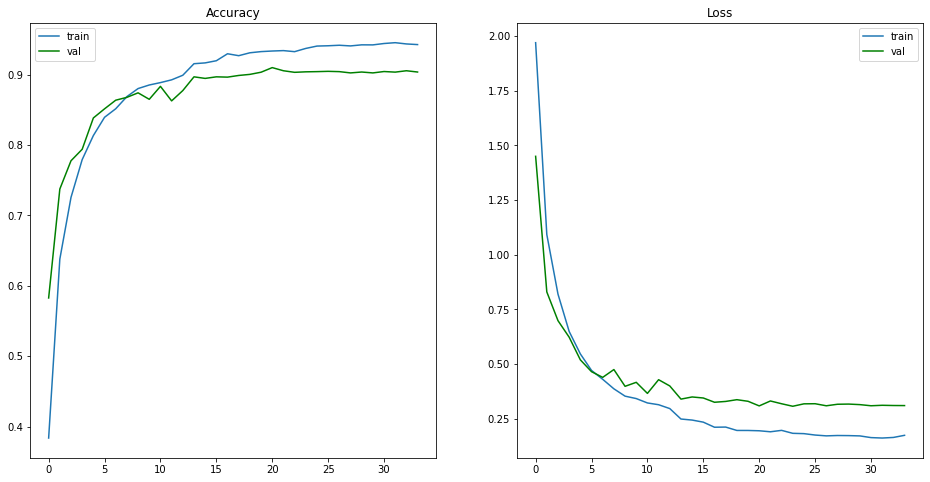

In [8]:
# Plot history
plot_history(history)

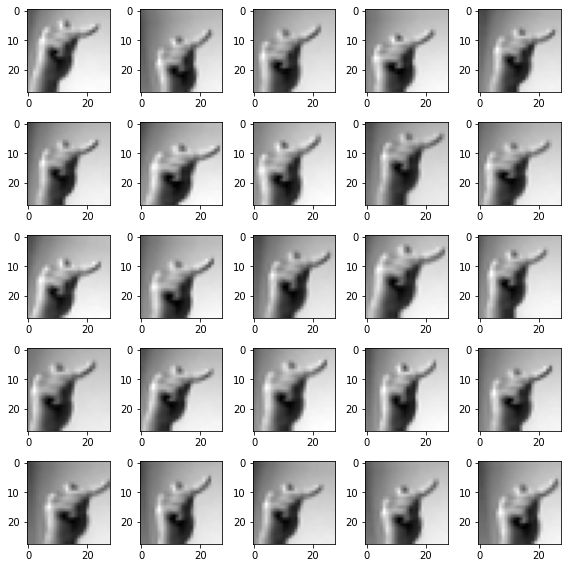

In [8]:
# Data aug
params = {
    'featurewise_center': False,             # set input mean to 0 over the dataset
    'samplewise_center': False,              # set each sample mean to 0
    'featurewise_std_normalization': False,  # divide inputs by std of the dataset
    'samplewise_std_normalization': False,   # divide each input by its std
    'zca_whitening': False,                  # apply ZCA whitening
    'rotation_range': 10,                    # randomly rotate images in the range (degrees, 0 to 180)
    'zoom_range': 0.1,                       # Randomly zoom image 
    'width_shift_range': 0.1,                # randomly shift images horizontally (fraction of total width)
    'height_shift_range': 0.1,               # randomly shift images vertically (fraction of total height)
    'horizontal_flip': False,                # randomly flip images
    'vertical_flip': False                   # randomly flip images
}
train_datagen = K.preprocessing.image.ImageDataGenerator(**params)
train_datagen.fit(train_X)

# Show data
example_df = train_df.sample(n=1).reset_index(drop=True)
example_X, example_Y = prepare_data(example_df)
example_datagen = K.preprocessing.image.ImageDataGenerator(**params)
example_datagen.fit(example_X)

plt.figure(figsize=(8, 8))
for i, (X_batch, Y_batch) in zip(range(25), example_datagen.flow(example_X, example_Y)):
    plt.subplot(5, 5, i+1)
    X_batch.resize(IMAGE_SIZE)
    plt.imshow(X_batch, cmap='gray')
plt.tight_layout()

In [20]:
# Init Model
model = K.models.Sequential([
    K.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', 
                    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    K.layers.MaxPooling2D((2, 2), strides=2),
    K.layers.Dropout(0.2),

    K.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    K.layers.MaxPooling2D((2, 2), strides=2),
    K.layers.Dropout(0.2),

    K.layers.Flatten(),
    K.layers.Dense(120),
    K.layers.Dense(84),

    K.layers.Dense(25, activation='softmax'),
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)


history_aug = model.fit_generator(
    train_datagen.flow(train_X, train_Y),
    epochs=50,
    validation_data=(test_X, test_Y),
    callbacks= [
        K.callbacks.EarlyStopping(patience=10),
        K.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    ])
model.save('model_06_v301.h5')

Epoch 1/50
858/858 [==============================] - 35s 41ms/step - loss: 1.9243 - acc: 0.4004 - val_loss: 0.9699 - val_acc: 0.6788
Epoch 2/50
858/858 [==============================] - 22s 26ms/step - loss: 1.0144 - acc: 0.6671 - val_loss: 0.5616 - val_acc: 0.8162
Epoch 3/50
858/858 [==============================] - 20s 24ms/step - loss: 0.7977 - acc: 0.7326 - val_loss: 0.4216 - val_acc: 0.8787
Epoch 4/50
858/858 [==============================] - 22s 26ms/step - loss: 0.6867 - acc: 0.7705 - val_loss: 0.4404 - val_acc: 0.8618
Epoch 5/50
858/858 [==============================] - 22s 26ms/step - loss: 0.6225 - acc: 0.7911 - val_loss: 0.3606 - val_acc: 0.8912
Epoch 6/50
858/858 [==============================] - 21s 25ms/step - loss: 0.5776 - acc: 0.8095 - val_loss: 0.3623 - val_acc: 0.8882
Epoch 7/50
858/858 [==============================] - 21s 25ms/step - loss: 0.5486 - acc: 0.8165 - val_loss: 0.3471 - val_acc: 0.8864

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00

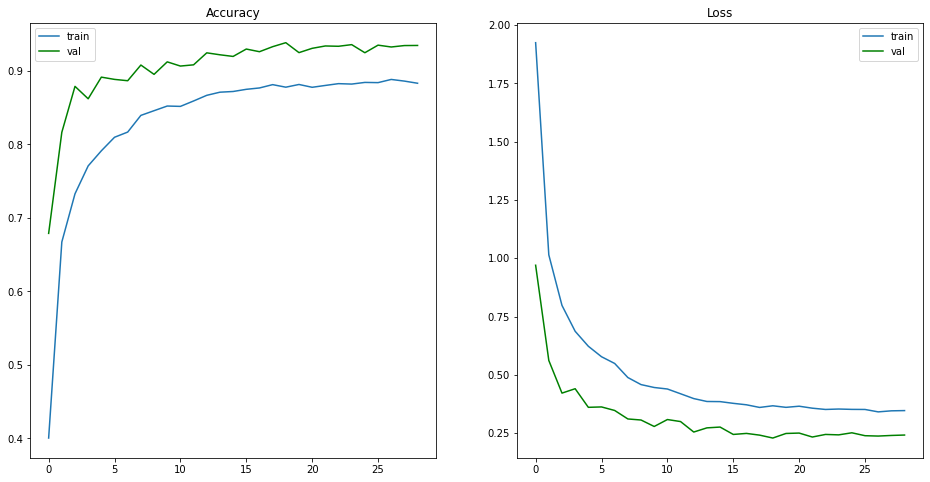

In [21]:
plot_history(history_aug)

In [7]:
params = {
    'pad_width': ((0, 0), (2, 2), (2, 2), (0, 0)),
    'mode':'edge',
}
train_images = np.pad(np.concatenate([train_X, train_X, train_X], axis=-1), **params)
test_images = np.pad(np.concatenate([test_X, test_X, test_X], axis=-1), **params)

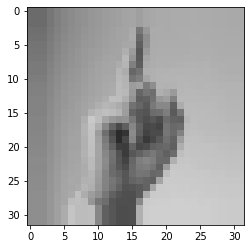

In [8]:
plt.imshow(train_images[0])

In [9]:
pre_trained_model = K.applications.vgg16.VGG16(input_shape=(32, 32, 3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = K.layers.GlobalAveragePooling2D()(last_output)
x = K.layers.Dense(256, activation='relu')(x)
x = K.layers.Dense(256, activation='relu')(x)
x = K.layers.Dense(25, activation='softmax')(x)

model = K.models.Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
bloc

In [10]:
history = model.fit(
    train_images, train_Y,
    epochs=50,
    validation_data=(test_images, test_Y),
    callbacks= [
        K.callbacks.EarlyStopping(patience=10),
        K.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    ])
# model.save('model_06_v400.h5')

Instructions for updating:
Use tf.cast instead.
Train on 27455 samples, validate on 7172 samples
Epoch 1/50
27455/27455 [==============================] - 380s 14ms/step - loss: 1.1542 - acc: 0.5750 - val_loss: 0.4880 - val_acc: 0.8445
Epoch 2/50
27455/27455 [==============================] - 392s 14ms/step - loss: 0.0999 - acc: 0.9671 - val_loss: 0.1468 - val_acc: 0.9590
Epoch 3/50
27455/27455 [==============================] - 383s 14ms/step - loss: 0.0791 - acc: 0.9794 - val_loss: 0.4089 - val_acc: 0.9212
Epoch 4/50
27455/27455 [==============================] - 404s 15ms/step - loss: 0.1637 - acc: 0.9768 - val_loss: 0.4466 - val_acc: 0.9182

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
27455/27455 [==============================] - 405s 15ms/step - loss: 0.0099 - acc: 0.9978 - val_loss: 0.0759 - val_acc: 0.9773
Epoch 6/50
27455/27455 [==============================] - 377s 14ms/step - loss: 1.2995e-04 - acc: 1.0000 - val_loss: 0.0688 - 

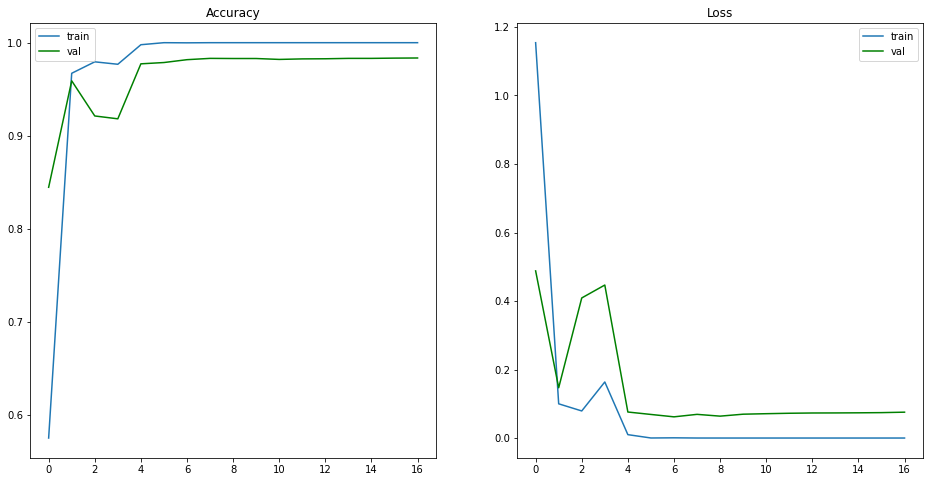

In [11]:
plot_history(history)